In [1]:
import os
import pandas as pd
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import *
import src.utils as utils
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Normalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


nba_teams = teams.get_teams()
fp_team = "./data/all_games.parquet.gzip"

if not os.path.exists(fp_team):
    print("data not found")
    all_games = pd.DataFrame()

    for team in nba_teams:
        team_id = team.get("id")
        gamefinder = leaguegamefinder.LeagueGameFinder(
            team_id_nullable=team_id,
            league_id_nullable=LeagueIDNullable().nba,
            season_type_nullable=SeasonType().regular,
        )

        team_games = gamefinder.get_data_frames()[0]
        all_games = pd.concat([all_games, team_games])
    all_games.to_parquet(fp_team, index=False)
else:
    print("data found local")
    all_games = pd.read_parquet(fp_team)

franchise_founding_dates = {team["id"]: team["year_founded"] for team in nba_teams}

all_games["GAME_DATE"] = pd.to_datetime(all_games["GAME_DATE"])
all_games = all_games.sort_values(["GAME_DATE", "GAME_ID"]).reset_index(drop=True)

# Apply the function to calculate plus-minus
all_games = utils.calculate_plus_minus(all_games)
all_games["DAYS_SINCE_LAST_GAME"] = (
    all_games.groupby(["SEASON_ID", "TEAM_ID"])["GAME_DATE"].diff().dt.days
)

all_games = utils.calculate_head_to_head(all_games)
all_games = utils.calculate_recent_performance(all_games, windows=[3, 10])
all_games = utils.calculate_home_away_splits(all_games)
all_games = utils.calculate_rest_days(all_games)
all_games = utils.calculate_franchise_age(all_games, franchise_founding_dates)
all_games = utils.calculate_cumulative_season_performance(all_games)

data found local


In [3]:
# Define the features and targets
data = all_games.copy()

target_win = "WL"
target_plus_minus = "PLUS_MINUS"

# Convert WL to boolean
data[target_win] = data[target_win].apply(lambda x: 1 if x=='W' else 0)

# Define meta columns that are not features
meta_cols = [
    "SEASON_ID",
    "TEAM_ID",
    "TEAM_ABBREVIATION",
    "TEAM_NAME",
    "GAME_ID",
    "GAME_DATE",
    "MATCHUP",
    "HOME_GAME"
]

# Define the feature columns
feature_cols = [col for col in data.columns if col not in [target_win, target_plus_minus] + meta_cols]

# Separate home and away features
home_games = data[data["HOME_GAME"]].set_index("GAME_ID")
away_games = data[~data["HOME_GAME"]].set_index("GAME_ID")

# Ensure the indices (GAME_ID) are aligned
home_games = home_games.loc[home_games.index.isin(away_games.index)]
away_games = away_games.loc[home_games.index]

# Features for home and away teams
home_features = home_games[feature_cols]
away_features = away_games[feature_cols]

# Targets for home games
home_targets = home_games[[target_win, target_plus_minus]].shift(-1).dropna()

# Split the data into training and testing sets while keeping the index for correspondence
X_home_train, X_home_test, y_home_train, y_home_test = train_test_split(home_features.iloc[1:], home_targets, test_size=0.2, random_state=42)
X_away_train, X_away_test = away_features.loc[X_home_train.index], away_features.loc[X_home_test.index]

tf.keras.backend.clear_session()

# Normalize the input features
normalizer_home = Normalization(axis=-1)
normalizer_home.adapt(X_home_train.to_numpy())

normalizer_away = Normalization(axis=-1)
normalizer_away.adapt(X_away_train.to_numpy())

# Define model inputs
home_input = Input(shape=(len(X_home_train.columns),), name="home_input")
away_input = Input(shape=(len(X_away_train.columns),), name="away_input")

# Apply normalization
norm_home = normalizer_home(home_input)
norm_away = normalizer_away(away_input)

# Concatenate the inputs
concatenated = Concatenate()([norm_home, norm_away])

# Define the rest of the model
dense1 = Dense(128, activation='relu')(concatenated)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)
dense4 = Dense(16, activation='relu')(dense3)

# Output layer for binary classification (Home win or not)
output_home_win = Dense(1, activation='sigmoid', name="home_win")(dense4)

# Output layer for regression (Point difference)
output_point_diff = Dense(1, name="point_diff")(dense4)

# Create the model
model = Model(inputs=[home_input, away_input], outputs=[output_home_win, output_point_diff])

# Compile the model
model.compile(optimizer='adam',
              loss={'home_win': 'binary_crossentropy', 'point_diff': 'mean_squared_error'},
              metrics={'home_win': 'accuracy', 'point_diff': 'mse'})

In [5]:
X_home_train.columns

Index(['MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'DAYS_SINCE_LAST_GAME', 'HEAD_TO_HEAD_HOME_WINS',
       'HEAD_TO_HEAD_AWAY_WINS', 'AVG_3_GAME_PERFORMANCE', 'WIN_PCT_3_GAMES',
       'AVG_10_GAME_PERFORMANCE', 'WIN_PCT_10_GAMES', 'HOME_PLUS_MINUS',
       'HOME_WIN_PCT', 'AWAY_PLUS_MINUS', 'AWAY_WIN_PCT', 'REST_DAYS',
       'FRANCHISE_AGE', 'CUMULATIVE_SEASON_PLUS_MINUS',
       'CUMULATIVE_SEASON_WINS', 'CUMULATIVE_SEASON_LOSSES'],
      dtype='object')

In [5]:
# Train the model
history = model.fit(
    [X_home_train, X_away_train], 
    {'home_win': y_home_train[target_win], 'point_diff': y_home_train[target_plus_minus]},
    validation_data=([X_home_test, X_away_test], 
                     {'home_win': y_home_test[target_win], 'point_diff': y_home_test[target_plus_minus]}),
    epochs=20,
    batch_size=32
)

# Save the model
model.save('home_away_model.h5')

# Evaluate the model
results = model.evaluate([X_home_test, X_away_test], 
                         {'home_win': y_home_test[target_win], 'point_diff': y_home_test[target_plus_minus]})

print("Test Loss, Test Accuracy, Test MSE:", results)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['home_win_accuracy'], label='Home Win Accuracy')
    plt.plot(history.history['val_home_win_accuracy'], label='Val Home Win Accuracy')
    plt.title('Home Win Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['point_diff_mse'], label='Point Difference rmse')
    plt.plot(history.history['val_point_diff_mse'], label='Val Point Difference rmse')
    plt.title('Point Difference Mean Squared Error')
    plt.xlabel('Epochs')
    plt.ylabel('rmse')
    plt.legend()

    plt.show()

plot_history(history)

Epoch 1/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - home_win_accuracy: 0.3945 - loss: nan - point_diff_mse: nan - val_home_win_accuracy: 0.3988 - val_loss: nan - val_point_diff_mse: nan
Epoch 2/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - home_win_accuracy: 0.3964 - loss: nan - point_diff_mse: nan - val_home_win_accuracy: 0.3988 - val_loss: nan - val_point_diff_mse: nan
Epoch 3/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - home_win_accuracy: 0.3988 - loss: nan - point_diff_mse: nan - val_home_win_accuracy: 0.3988 - val_loss: nan - val_point_diff_mse: nan
Epoch 4/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - home_win_accuracy: 0.3979 - loss: nan - point_diff_mse: nan - val_home_win_accuracy: 0.3988 - val_loss: nan - val_point_diff_mse: nan
Epoch 5/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - home_win_accuracy: 0.3964 - loss: nan - point_diff_mse: nan - val_home_win_accuracy: 0.3988 - val_loss: nan - val_point_diff_mse: nan
Epoch 6/20
1167/1167 ━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

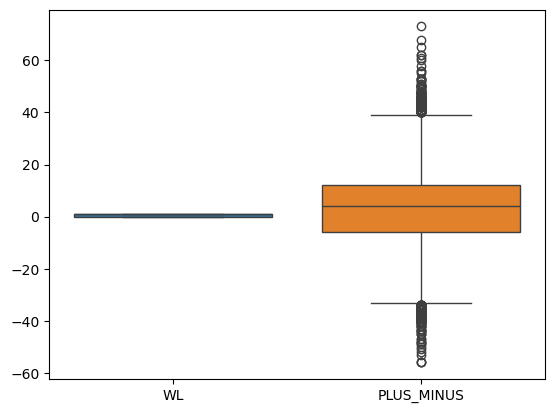

In [9]:
import seaborn as sns
sns.boxplot(data=y_home_train)
plt.show()

In [3]:
def find_identical_or_oposite_columns(df1, df2):
    # Find columns that exist in both data frames
    common_columns = set(df1.columns).intersection(set(df2.columns))
    
    identical_columns = []
    
    for col in common_columns:
        if df1[col].equals(df2[col]):
            identical_columns.append(col)
        elif df1[col].dtype == 'bool' and df2[col].dtype == 'bool' and df1[col].equals(~df2[col]):
            identical_columns.append(col)
    
    return identical_columns

fx = all_games.copy()
fx['WL'] = fx['WL'].apply(lambda x: x == 'W')
hom = fx.loc[all_games['HOME_GAME']].set_index("GAME_ID")
awy = fx.loc[~all_games['HOME_GAME']].set_index("GAME_ID")

identical_columns = find_identical_or_oposite_columns(hom.select_dtypes('number').abs(), awy.select_dtypes('number').abs())
print("Identical columns:", identical_columns)

# Checking boolean columns
identical_boolean_columns = find_identical_or_oposite_columns(hom.select_dtypes('bool'), awy.select_dtypes('bool'))
print("Identical or Opposite Boolean columns:", identical_boolean_columns)

del fx, hom, awy, identical_columns, identical_boolean_columns

Identical columns: ['PLUS_MINUS']
Identical or Opposite Boolean columns: ['WL', 'HOME_GAME']
